In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import funcoes
import itertools
from sklearn.metrics import accuracy_score

sns.set_style('darkgrid')
%matplotlib inline

In [3]:
df = pd.read_csv('conhecimento.csv')
df['dia'] = df.id_cena.str[-3:].astype(int)

id_cenas = [
    # 'LS82260702016078', 
    'LS82260702017256', # 226_070
    # 'LS82210702016059', 
    'LS82210702017269', # 221_070
    # 'LS52210672002068', 
    'LS82210672017285', # 221_067
    # 'LS82210742016059', 
    'LS82210742018128', # 221_074
]
col_sum = ['previsao', 'verdade', 'porcentagem', 'id_cena', 'caso']

In [19]:
def gera_teste_modelo_caso2(id_cena):
    
    teste_original = df[df.id_cena==id_cena].copy().reset_index(drop=True)
    teste = teste_original.copy()
    teste['verifica'] = 0

    # Modelo
    modelo_inteiro = df[~(df.id_cena==id_cena)].copy()

    modelo_inteiro_1 = modelo_inteiro[modelo_inteiro.verifica==1].copy()
    modelo_inteiro_3_full = modelo_inteiro[modelo_inteiro.verifica==3].copy()

    id3 = np.random.choice(modelo_inteiro_3_full.id, len(modelo_inteiro_1), replace=False) 
    modelo_inteiro_3 = modelo_inteiro_3_full[modelo_inteiro_3_full.id.isin(id3)]

    modelo = pd.concat([modelo_inteiro_1, modelo_inteiro_3]).reset_index(drop=True)

    return teste, teste_original, modelo
def resultado(teste, teste_original, pred, verdade,verifica=1):
    r = pd.merge(teste[['id', pred]], teste_original[['id', verdade]], on='id')
    r['v'] = r[pred].astype(str) + r[verdade].astype(str)
    
    try:
        x = len(r[(r[verdade]==verifica) & (r[pred] == verifica)])
        v = len(r[r[verdade]==verifica])
        p = int((x*100)/v)
    except:
        return [0, 0, 0]
    return [x, v, p]

In [11]:
def plt_desv(d, desvio, media, x, cor):
    depois = media+(d*desvio)
    antes = media-(d*desvio)
    qta = len(x[(x>antes) & (x<depois)])
    label = int((qta*100)/len(x))
    
    plt.axvline(depois, linestyle='dashed', linewidth=0.5, c=cor)
    plt.text(depois, (d*2)/10, ' %s (%s%%)' % (d, label), color=cor)
    
    plt.axvline(antes, linestyle='dashed', linewidth=0.5, c=cor)
    plt.text(antes, (d*2)/10, ' -%s' % d, color=cor)
def densidade(col):
    fig, ax = plt.subplots()
    ax.set_title(col)
    
    ################### - 1 - #####################
    x = df1[col]
    media = np.mean(x)
    mediana = np.median(x)
    desvio = np.std(x)
    x.plot.kde(ax=ax, legend=False, c='r', figsize=(15,8))
    plt.axvline(media, linestyle='dashed', linewidth=2, c='red')
    plt.text(media,3, ' Média', color='red')
    
    plt.axvline(mediana, linestyle='solid', linewidth=2, c='red')
    plt.text(mediana,0, ' Mediana', color='red')

    plt_desv(1, desvio, media, x, '#ffa284')
    plt_desv(2, desvio, media, x, '#ff7b5a')
    plt_desv(3, desvio, media, x, 'red')
    ################### - 3 - #####################
    x = df3_full[col]
    media = np.mean(x)
    mediana = np.median(x)
    desvio = np.std(x)
    x.plot.kde(ax=ax, legend=False, c='b', figsize=(15,8))
    plt.axvline(media, linestyle='dashed', linewidth=2, c='blue')
    plt.text(media,3, ' Média', color='blue')
    plt.axvline(mediana, linestyle='solid', linewidth=2, c='blue')
    plt.text(mediana,0, ' Mediana', color='red')

    plt_desv(1, desvio, media, x, '#cfb1ff')
    plt_desv(2, desvio, media, x, '#9265ff')
    plt_desv(3, desvio, media, x, 'blue')
def distribuicao(col):
    fig, ax = plt.subplots()
    ax.set_title(col)
    df1[col].plot(ax=ax, legend=False, c='r', figsize=(15,8))
    df3[col].plot(ax=ax, legend=False, c='b', figsize=(15,8))
    
def compara(col):
    fig, ax = plt.subplots()
    ax.set_title(col)
    df1[col].plot.kde(ax=ax, legend=False, c='r', figsize=(15,8), label='df1')
    df3[col].plot.kde(ax=ax, legend=False, c='b', figsize=(15,8), label='df3_amostra')
    df3_full[col].plot.kde(ax=ax, legend=False, c='g', figsize=(15,8), label='df3_full')
    ax.legend(loc='upper left')

In [5]:
melhores_colunas = ['ndvi', 'nbrl', 'dif_ndvi', 'dif_dnbrl', 'medianb2', 'medianb3', 'medianb4', 'medianb5', 'medianb6', 'medianb7']

In [6]:
teste, teste_original, modelo = gera_teste_modelo_caso2('LS82210742018128')

In [7]:
print('RF - Classifica dado usando as colunas', melhores_colunas)
rf_clas = RandomForestClassifier(n_jobs=8, n_estimators=100, max_features=len(melhores_colunas), random_state=0, max_depth=3, min_samples_split=5)
rf_clas.fit(modelo[melhores_colunas], modelo.verifica)

RF - Classifica dado usando as colunas ['ndvi', 'nbrl', 'dif_ndvi', 'dif_dnbrl', 'medianb2', 'medianb3', 'medianb4', 'medianb5', 'medianb6', 'medianb7']


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [8]:
teste['rf'] = rf_clas.predict(teste[melhores_colunas])

In [9]:
teste['rf_1'] = rf_clas.predict_proba(teste[melhores_colunas])[:, 0]

In [12]:
teste.head(2)

,ndvi,nbrl,dif_ndvi,dif_dnbrl,medianb2,medianb3,medianb4,medianb5,medianb6,medianb7,id_cena,id,verifica,orb_pto,dia,rf,rf_1
0,0.162181,0.032588,0.275118,0.224989,0.093149,0.077148,0.100090,0.139473,0.158032,0.131164,LS82210742018128,7531957,0,221_074,128,1,0.928462
1,0.306417,0.235064,0.412628,0.496806,0.149150,0.166385,0.219121,0.410860,0.431184,0.255387,LS82210742018128,7534930,0,221_074,128,3,0.014597


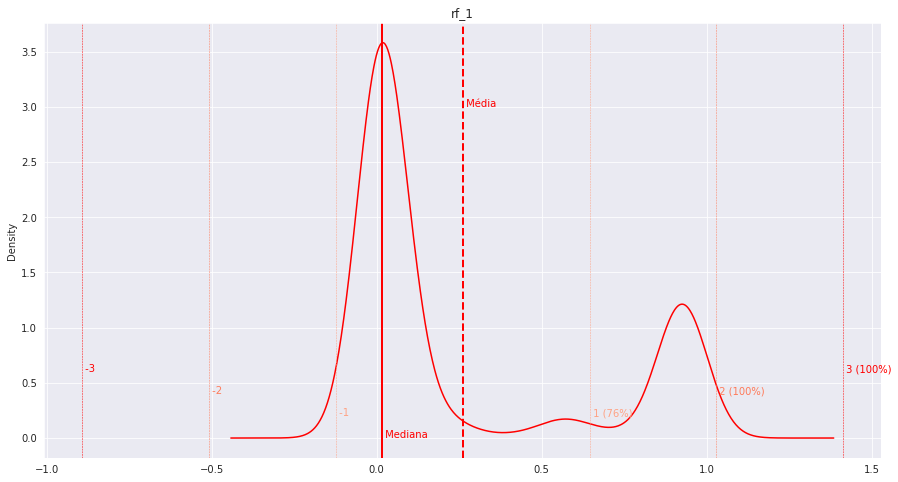

In [16]:
col = 'rf_1'
ig, ax = plt.subplots()
ax.set_title(col)

################### - 1 - #####################
x = teste[col]
media = np.mean(x)
mediana = np.median(x)
desvio = np.std(x)
x.plot.kde(ax=ax, legend=False, c='r', figsize=(15,8))
plt.axvline(media, linestyle='dashed', linewidth=2, c='red')
plt.text(media,3, ' Média', color='red')

plt.axvline(mediana, linestyle='solid', linewidth=2, c='red')
plt.text(mediana,0, ' Mediana', color='red')

plt_desv(1, desvio, media, x, '#ffa284')
plt_desv(2, desvio, media, x, '#ff7b5a')
plt_desv(3, desvio, media, x, 'red')

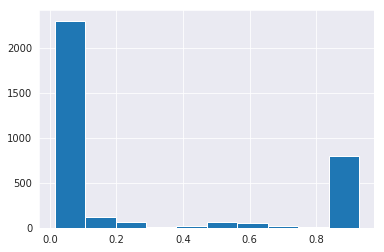

In [17]:
teste.rf_1.hist()

In [21]:
teste['avaliacao'] = teste.rf_1.apply(lambda x: 1 if x > 0.9 else 3)

In [26]:
y_pred = teste.sort_values('id').reset_index(drop=True)
y_true = teste_original.sort_values('id').reset_index(drop=True)
print(resultado(y_pred, y_true, 'avaliacao', 'verifica'))
print(resultado(y_pred, y_true, 'rf', 'verifica'))

[758, 1072, 70]
[914, 1072, 85]
